--- 1. Loading and Merging Data ---
Columns in df_cc: ['ID', 'cc_cons']
Renamed 'ID' to 'Customer_ID' in df_cc.
Columns in df_demog: ['ID', 'account_type', 'gender', 'age', 'Income', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction']
Renamed 'ID' to 'Customer_ID' in df_demog.
Columns in df_behavior: ['ID', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_cou

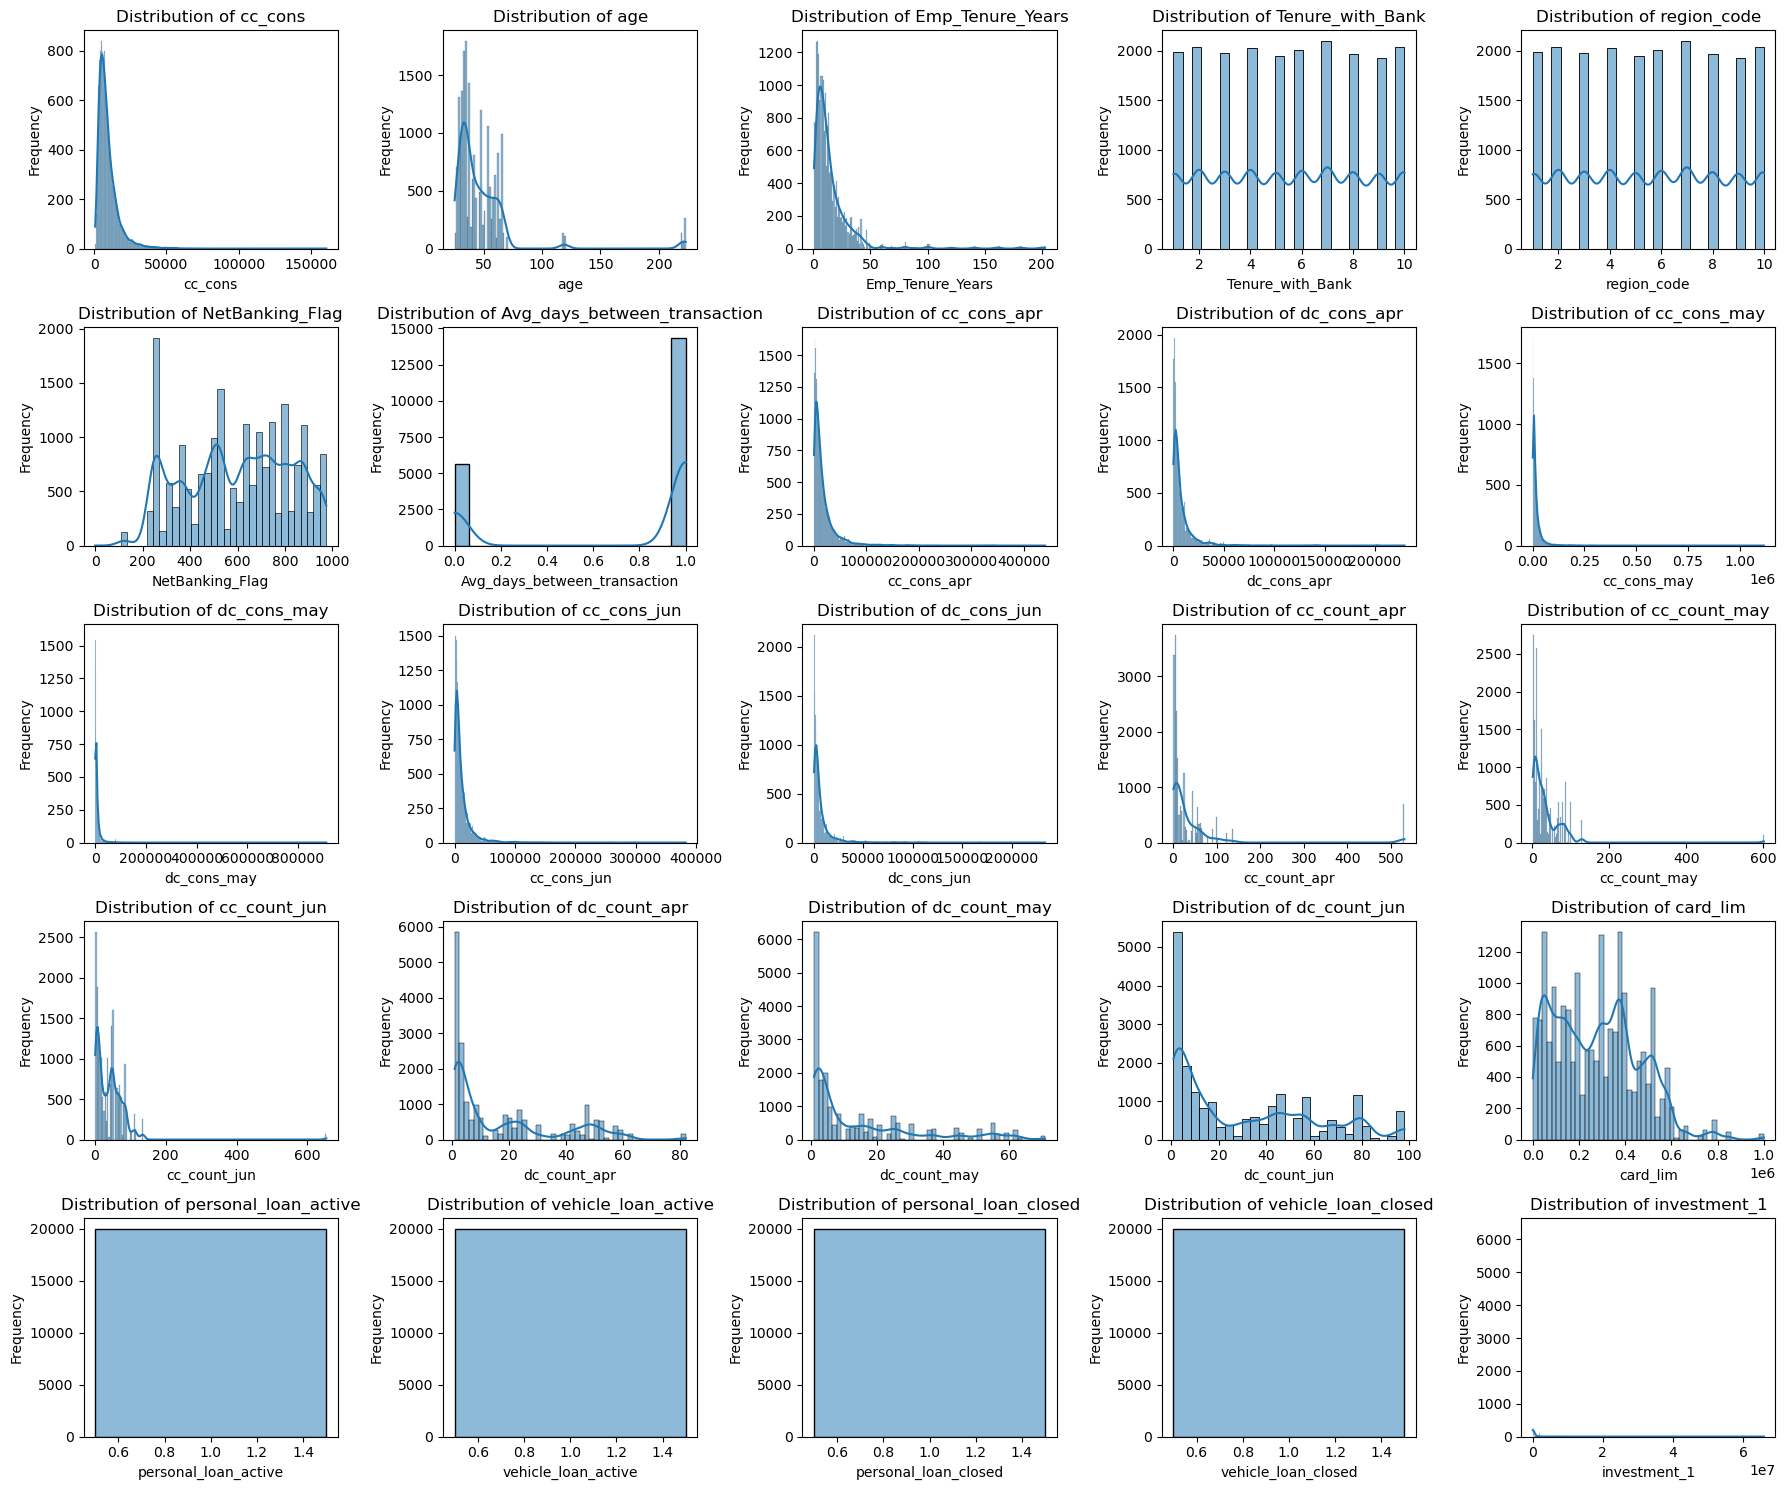


--- Visualizing Categorical Feature Distributions (Count Plots) ---


C:\Users\DELL\AppData\Local\Temp\ipykernel_17540\2831508677.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')
C:\Users\DELL\AppData\Local\Temp\ipykernel_17540\2831508677.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')
C:\Users\DELL\AppData\Local\Temp\ipykernel_17540\2831508677.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='viridis')
C:\Users\DELL\AppData\Local\Temp\ipykernel_17540\2831508677.py:164: FutureWarning: 

Passing `

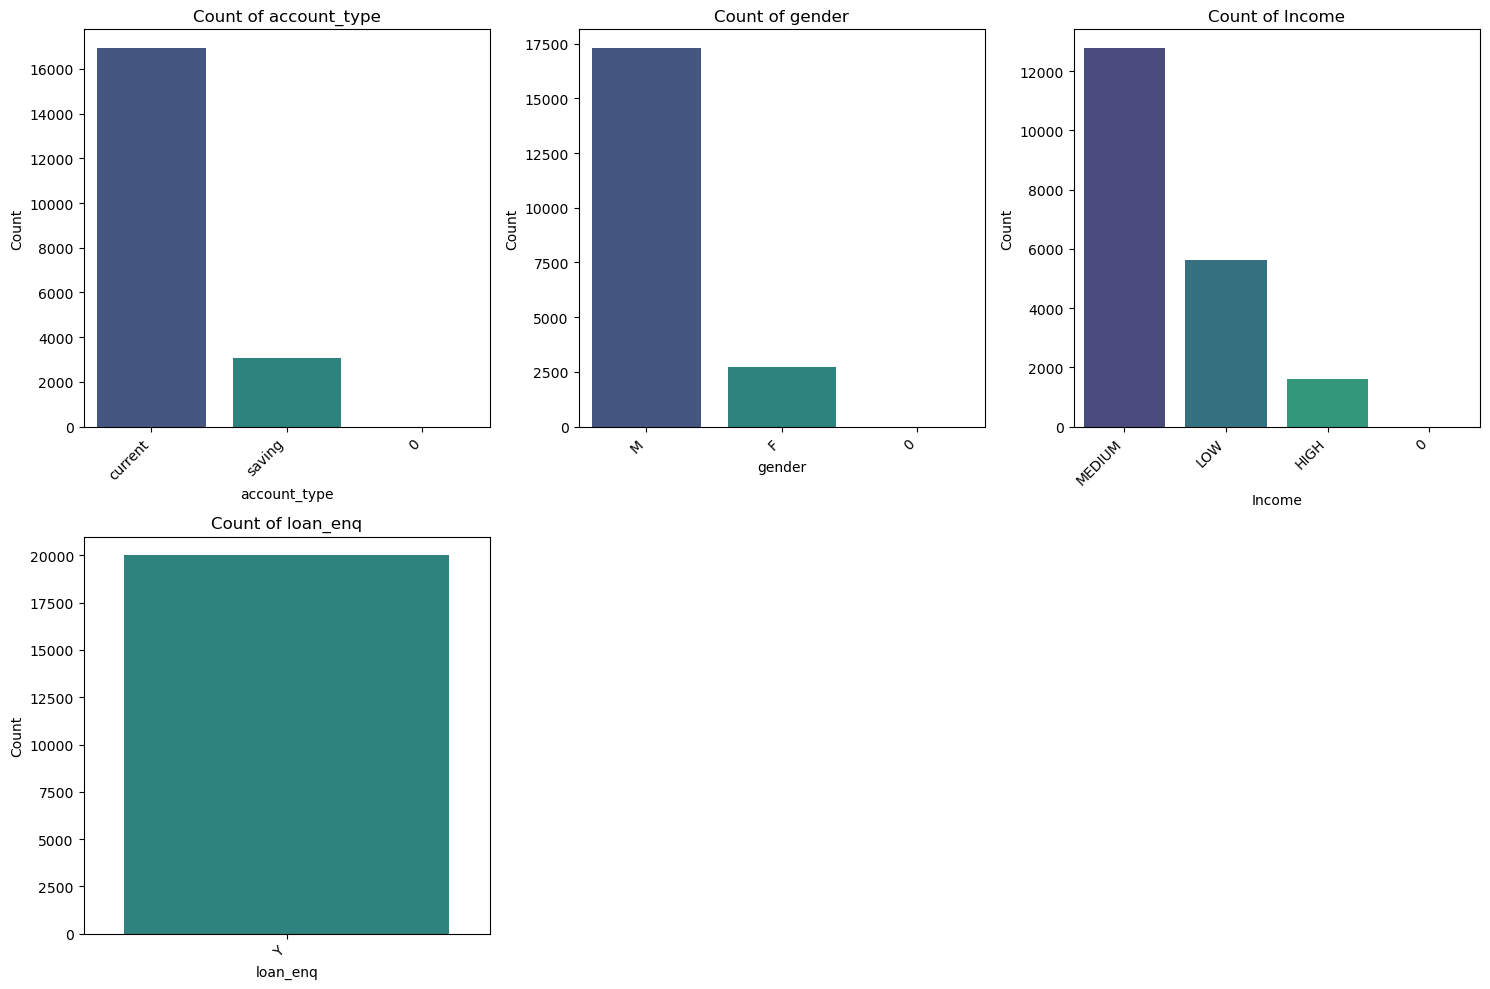


--- Correlation Heatmap of Numerical Features ---


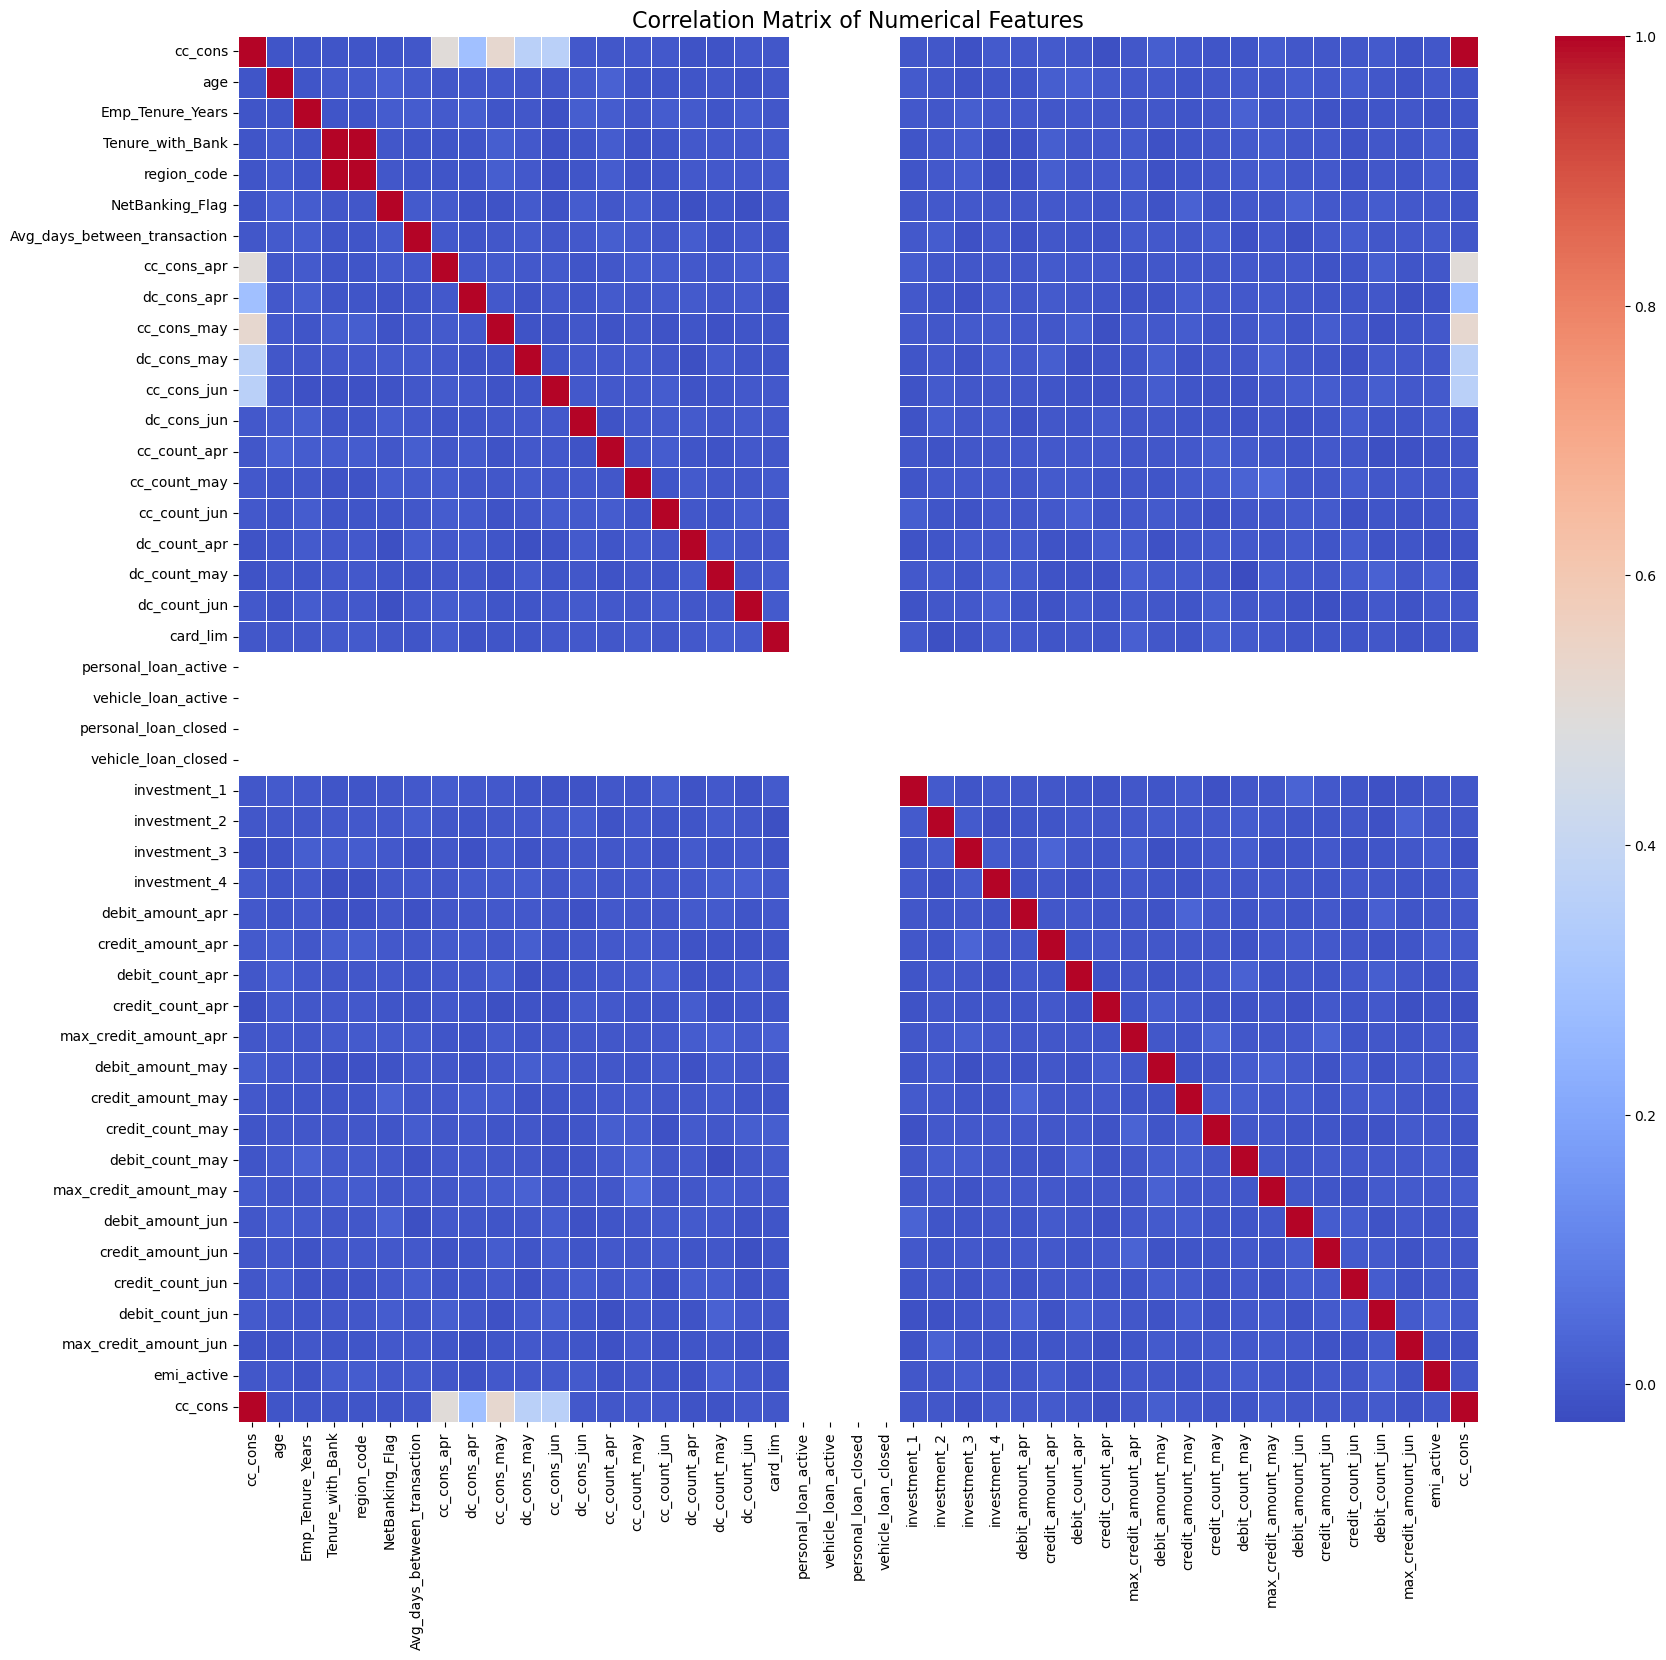


--- Correlation with Target Variable (cc_cons) ---
Type of correlations_with_target before sorting: <class 'pandas.core.frame.DataFrame'>
cc_cons                         1.000000
cc_cons                         1.000000
cc_cons_may                     0.524564
cc_cons_apr                     0.499045
dc_cons_may                     0.364082
cc_cons_jun                     0.362669
dc_cons_apr                     0.287075
debit_amount_may                0.012702
max_credit_amount_may           0.011302
investment_4                    0.006212
debit_count_jun                 0.006055
credit_amount_apr               0.005811
cc_count_may                    0.003901
cc_count_jun                    0.003642
dc_count_jun                    0.001842
debit_amount_apr                0.001745
credit_amount_may               0.001225
dc_cons_jun                     0.000361
investment_1                    0.000075
Avg_days_between_transaction    0.000067
investment_2                   -0.000939


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder # StandardScaler might be useful later

# --- Utility Functions (Assuming these are already defined in your notebook) ---
# If these are not defined, you'll need to add them here or ensure they are in a previous cell.

def continuous_var_summary(x):
    """Generates an audit report for a continuous variable."""
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                      x.quantile(0.10), x.quantile(0.25), x.quantile(0.50), x.quantile(0.75),
                      x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max()],
                     index=['N', 'NMISS', 'SUM', 'MEAN', 'MEDIAN', 'STD', 'VAR', 'MIN', 'P1',
                            'P5', 'P10', 'P25', 'P50', 'P75', 'P90', 'P95', 'P99', 'MAX'])

def categorical_var_summary(x):
    """Generates an audit report for a categorical variable."""
    mode_val = x.mode()[0] if not x.mode().empty else np.nan
    mode_freq = x.value_counts().max() if not x.value_counts().empty else 0
    mode_perc = (mode_freq / x.count()) * 100 if x.count() > 0 else 0
    return pd.Series([x.count(), x.isnull().sum(), mode_val, mode_freq, mode_perc],
                     index=['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

def missing_imputation(df, column_name, var_type):
    """
    Imputes missing values in a DataFrame column.
    Args:
        df (pd.DataFrame): The DataFrame.
        column_name (str): The name of the column to impute.
        var_type (str): 'continuous' or 'categorical'.
    Returns:
        pd.Series: The column with imputed values.
    """
    if var_type == 'continuous':
        return df[column_name].fillna(df[column_name].mean()) # Using mean for simplicity
    elif var_type == 'categorical':
        return df[column_name].fillna(df[column_name].mode()[0])
    else:
        return df[column_name] # No imputation if type is unknown

def create_dummies(df, column_names):
    """
    Creates dummy variables for specified categorical columns and drops original.
    Args:
        df (pd.DataFrame): The DataFrame.
        column_names (list): List of column names to convert to dummies.
    Returns:
        pd.DataFrame: DataFrame with dummy variables.
    """
    for col in column_names:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(col, axis=1)
    return df

def rmspe(y_true, y_pred):
    """
    Calculates the Root Mean Square Percentage Error (RMSPE).
    Args:
        y_true (np.array or pd.Series): Actual values.
        y_pred (np.array or pd.Series): Predicted values.
    Returns:
        float: The RMSPE value.
    """
    # Avoid division by zero for y_true values close to zero
    # Add a small epsilon to prevent division by zero for actual values that are 0
    # Or filter out rows where y_true is 0 if that's appropriate for the business context
    percentage_error = np.abs((y_true - y_pred) / (y_true + 1e-8)) # Add epsilon
    return np.sqrt(np.mean(np.square(percentage_error)))


# --- 1. Data Loading and Merging ---
print("--- 1. Loading and Merging Data ---")
try:
    # Corrected file paths and using pd.read_excel
    df_cc = pd.read_excel(r"C:\Users\DELL\OneDrive\Desktop\assignment\11. Capstone Case Study - Predict Cred Card Consumption\CreditConsumptionData.xlsx")
    print(f"Columns in df_cc: {df_cc.columns.tolist()}")
    if 'Customer_ID' not in df_cc.columns and 'ID' in df_cc.columns:
        df_cc.rename(columns={'ID': 'Customer_ID'}, inplace=True)
        print("Renamed 'ID' to 'Customer_ID' in df_cc.")
    elif 'Customer_ID' not in df_cc.columns:
        print("Warning: 'Customer_ID' or 'ID' not found in CreditConsumptionData.xlsx. Merge might fail.")


    df_demog = pd.read_excel(r"C:\Users\DELL\OneDrive\Desktop\assignment\11. Capstone Case Study - Predict Cred Card Consumption\CustomerDemographics.xlsx")
    print(f"Columns in df_demog: {df_demog.columns.tolist()}")
    if 'Customer_ID' not in df_demog.columns and 'ID' in df_demog.columns:
        df_demog.rename(columns={'ID': 'Customer_ID'}, inplace=True)
        print("Renamed 'ID' to 'Customer_ID' in df_demog.")
    elif 'Customer_ID' not in df_demog.columns:
        print("Warning: 'Customer_ID' or 'ID' not found in CustomerDemographics.xlsx. Merge might fail.")


    df_behavior = pd.read_excel(r"C:\Users\DELL\OneDrive\Desktop\assignment\11. Capstone Case Study - Predict Cred Card Consumption\CustomerBehaviorData.xlsx")
    print(f"Columns in df_behavior: {df_behavior.columns.tolist()}")
    if 'Customer_ID' not in df_behavior.columns and 'ID' in df_behavior.columns:
        df_behavior.rename(columns={'ID': 'Customer_ID'}, inplace=True)
        print("Renamed 'ID' to 'Customer_ID' in df_behavior.")
    elif 'Customer_ID' not in df_behavior.columns:
        print("Warning: 'Customer_ID' or 'ID' not found in CustomerBehaviorData.xlsx. Merge might fail.")


    # Merge dataframes
    df_merged = pd.merge(df_cc, df_demog, on='Customer_ID', how='left')
    df = pd.merge(df_merged, df_behavior, on='Customer_ID', how='left')

    print("Data loaded and merged successfully. Initial shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nFirst 5 rows of merged data:")
    print(df.head())

except FileNotFoundError as e:
    print(f"Error: One or more data files not found. Please ensure the specified paths are correct and the files exist.")
    print(e)
    # Exit or handle the error appropriately if files are missing
    exit() # Or raise an exception to stop execution
except KeyError as e:
    print(f"A KeyError occurred during merging. This usually means 'Customer_ID' column is missing after initial checks. Please verify column names in your Excel files.")
    print(e)
    exit()


# --- 2. Exploratory Data Analysis (EDA) and Visualizations ---
print("\n--- 2. Exploratory Data Analysis (EDA) and Visualizations ---")

# Separate numerical and categorical columns for visualization
numerical_cols_for_eda = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols_for_eda = df.select_dtypes(include='object').columns.tolist()

# Exclude 'Customer_ID' and 'cc_cons' (if it's the target) from numerical features for general correlation and distributions
if 'Customer_ID' in numerical_cols_for_eda:
    numerical_cols_for_eda.remove('Customer_ID')
# 'cc_cons' will be handled separately for target correlation, but can be in general distributions

print("\n--- Visualizing Numerical Feature Distributions (Histograms) ---")
# Plot histograms for numerical features
plt.figure(figsize=(18, 15))
for i, col in enumerate(numerical_cols_for_eda):
    if i >= 25: # Limit to first 25 for brevity, adjust as needed
        break
    plt.subplot(5, 5, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("\n--- Visualizing Categorical Feature Distributions (Count Plots) ---")
# Plot count plots for categorical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols_for_eda):
    if i >= 6: # Limit to first 6 for brevity, adjust as needed
        break
    plt.subplot(2, 3, i + 1)
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- Correlation Heatmap of Numerical Features ---")
# Calculate correlation matrix for numerical features
# Drop rows with NaN in 'cc_cons' for correlation calculation if you want correlation with target
df_corr = df[numerical_cols_for_eda + ['cc_cons']].dropna()
correlation_matrix = df_corr.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("\n--- Correlation with Target Variable (cc_cons) ---")
# Correlation of all features with the target variable 'cc_cons'
# Ensure 'cc_cons' is treated as numerical and non-missing for this analysis
df_target_corr = df[df['cc_cons'].notna()].copy()
# Impute numerical features for this specific correlation calculation if needed
for col in numerical_cols_for_eda:
    df_target_corr[col] = missing_imputation(df_target_corr, col, 'continuous')
# For categorical features, convert them to numerical (e.g., using LabelEncoder or dummies) for correlation.
# For simplicity, we'll just use numerical features for now.
# If you want to include categorical features, you'd need to encode them first.
# Example: df_target_corr = create_dummies(df_target_corr, categorical_cols_for_eda)

# Calculate correlations with 'cc_cons'
correlation_matrix_with_target = df_target_corr[numerical_cols_for_eda + ['cc_cons']].corr()
correlations_with_target = correlation_matrix_with_target['cc_cons']

# Diagnostic print to confirm the type before sorting
print(f"Type of correlations_with_target before sorting: {type(correlations_with_target)}")

# Ensure it's a Series before sorting (defensive check)
if isinstance(correlations_with_target, pd.DataFrame):
    # This block should ideally not be reached if the previous line works as intended
    # If it is a DataFrame, we take the first column, assuming it contains the correlation values.
    correlations_with_target = correlations_with_target.iloc[:, 0]
    print("Warning: correlations_with_target was a DataFrame, converted to Series for sorting.")

correlations_with_target = correlations_with_target.sort_values(ascending=False)
print(correlations_with_target)

# --- 3. Separate Data for Training and Prediction ---
# Customers with non-missing 'cc_cons' for training the model
df_train_set = df[df['cc_cons'].notna()].copy()

# Customers with missing 'cc_cons' for prediction
df_predict_set = df[df['cc_cons'].isna()].copy()

print(f"\nTraining set shape (cc_cons not missing): {df_train_set.shape}")
print(f"Prediction set shape (cc_cons missing): {df_predict_set.shape}")

# --- 4. Data Preprocessing for Training Set ---
print("\n--- 4. Preprocessing Training Data ---")

# Identify feature columns (excluding Customer_ID and cc_cons)
# This list will contain all columns that are potential features
all_potential_features = [col for col in df_train_set.columns if col not in ['Customer_ID', 'cc_cons']]

# Separate numerical and categorical features for imputation and dummy creation
numerical_features = df_train_set[all_potential_features].select_dtypes(include=np.number).columns.tolist()
categorical_features = df_train_set[all_potential_features].select_dtypes(include='object').columns.tolist()

# Explicitly remove 'Customer_ID' from categorical_features if it was mistakenly included
# This ensures Customer_ID is never dropped by create_dummies
if 'Customer_ID' in categorical_features:
    categorical_features.remove('Customer_ID')

# Impute missing values in the training set features
for col in numerical_features:
    df_train_set[col] = missing_imputation(df_train_set, col, 'continuous')
    print(f"Imputed numerical column: {col}")

for col in categorical_features:
    df_train_set[col] = missing_imputation(df_train_set, col, 'categorical')
    print(f"Imputed categorical column: {col}")

# Create dummy variables for categorical features in the training set
df_train_set_processed = create_dummies(df_train_set, categorical_features)
print(f"Created dummies for categorical features. New training set shape: {df_train_set_processed.shape}")

# --- 5. Feature and Target Separation for Training ---
# Add a diagnostic print to check columns before dropping
print(f"Columns in df_train_set_processed before dropping: {df_train_set_processed.columns.tolist()}")

X_train_full = df_train_set_processed.drop(['Customer_ID', 'cc_cons'], axis=1)
y_train_full = df_train_set_processed['cc_cons']

# Align columns to ensure consistency (important if some dummy columns were not created due to missing categories)
# For now, we assume X_train_full has all necessary columns.

# --- 6. Train-Validation Split ---
# Splitting the training data further into train and validation sets for model evaluation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

print(f"\nTraining data split: X_train {X_train.shape}, X_val {X_val.shape}")

# --- 7. Model Training and Evaluation ---
print("\n--- 7. Model Training and Evaluation ---")

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    rmspe_score = rmspe(y_val, y_pred) # Calculate RMSPE

    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'RMSPE': rmspe_score}

    print(f"  {name} Evaluation:")
    print(f"    Mean Absolute Error (MAE): {mae:.2f}")
    print(f"    Mean Squared Error (MSE): {mse:.2f}")
    print(f"    Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"    R-squared (R2): {r2:.4f}")
    print(f"    Root Mean Square Percentage Error (RMSPE): {rmspe_score:.4f}")


# Display all results in a DataFrame for easy comparison
results_df = pd.DataFrame(results).T
print("\n--- Model Comparison ---")
print(results_df.round(4))

# Determine the best model based on R-squared (or other preferred metric, e.g., lowest RMSPE)
# For regression, higher R2 is generally better, lower MAE/MSE/RMSE/RMSPE are better.
# Based on the problem statement, RMSPE is the primary evaluation metric.
best_model_name = results_df['RMSPE'].idxmin() # Select model with lowest RMSPE
best_model = models[best_model_name]
print(f"\nBest performing model based on Root Mean Square Percentage Error (RMSPE): {best_model_name}")

# --- 8. Preprocessing for Prediction Set (for customers with missing cc_cons) ---
print("\n--- 8. Preprocessing Prediction Data ---")

# Apply the same imputation logic as used for the training set
for col in numerical_features:
    df_predict_set[col] = missing_imputation(df_predict_set, col, 'continuous')
    print(f"Imputed numerical column in prediction set: {col}")

for col in categorical_features:
    df_predict_set[col] = missing_imputation(df_predict_set, col, 'categorical')
    print(f"Imputed categorical column in prediction set: {col}")

# Create dummy variables for categorical features in the prediction set
df_predict_set_processed = create_dummies(df_predict_set, categorical_features)
print(f"Created dummies for categorical features in prediction set. New shape: {df_predict_set_processed.shape}")

# Align columns of the prediction set with the training set features (X_train_full)
# This is crucial to ensure the prediction set has the exact same columns in the same order.
missing_cols_in_predict = set(X_train_full.columns) - set(df_predict_set_processed.columns)
for c in missing_cols_in_predict:
    df_predict_set_processed[c] = 0 # Add missing columns and fill with 0

extra_cols_in_predict = set(df_predict_set_processed.columns) - set(X_train_full.columns)
df_predict_set_processed = df_predict_set_processed.drop(columns=list(extra_cols_in_predict)) # Drop extra columns

# Ensure the order of columns is identical
X_predict = df_predict_set_processed[X_train_full.columns]

print(f"Aligned prediction set columns with training set. Final prediction set shape: {X_predict.shape}")
print(f"Number of columns in training features: {len(X_train_full.columns)}")
print(f"Number of columns in prediction features: {len(X_predict.columns)}")
# Verify that column names and order are identical
# print(f"Are columns identical? {list(X_train_full.columns) == list(X_predict.columns)}")


# --- 9. Predict Credit Consumption for Missing Values ---
print("\n--- 9. Predicting Missing Credit Consumption ---")

if not X_predict.empty:
    predictions_for_missing = best_model.predict(X_predict)
    df_predict_set['predicted_cc_cons'] = predictions_for_missing

    print("\nPredictions for customers with initially missing 'cc_cons':")
    print(df_predict_set[['Customer_ID', 'predicted_cc_cons']].head(10)) # Display top 10 predictions

    # --- Final Output: Save Predicted Values ---
    output_filename = 'predicted_credit_consumption_for_missing.csv'
    df_predict_set[['Customer_ID', 'predicted_cc_cons']].to_csv(output_filename, index=False)
    print(f"\nFinal predicted values for customers with missing 'cc_cons' saved to: {output_filename}")
else:
    print("No customers with missing 'cc_cons' found to predict.")

print("\n--- Analysis Complete ---")
